# Distance measurement using Contours with opencv in python

In [1]:
#imports
from os import path
import cv2 as cv
import numpy as np
from scipy.spatial import distance as dist
from imutils import perspective, contours, grab_contours, is_cv2
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
curdir = path.abspath("")

In [3]:
def midpoint(ptA, ptB):
    return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

In [4]:
# load the image, convert it to grayscale, and blur it slightly
image = cv.imread(path.abspath(path.join(curdir,"sample1.jpg")))

sticker_diameter = 30 #mm

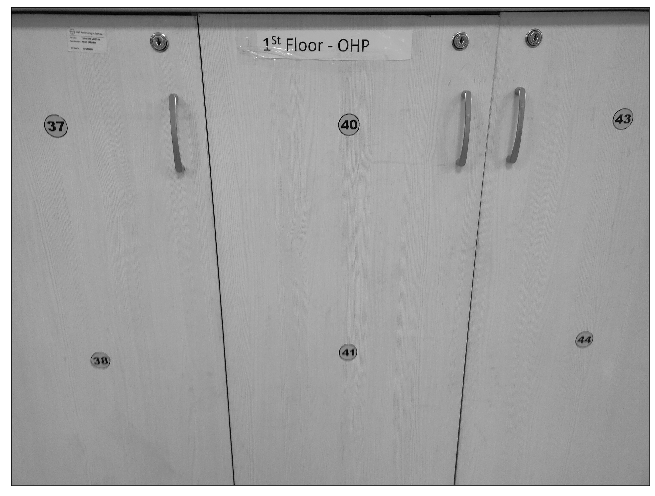

In [5]:
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
plt.style.use("seaborn-poster")
plt.xticks([]),plt.yticks([])
plt.imshow(gray,cmap="gray")

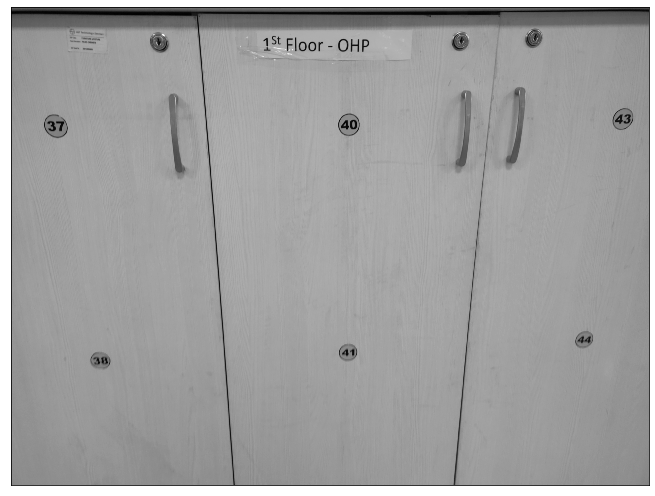

In [6]:
blured = cv.GaussianBlur(gray, (9, 9), 0)
plt.xticks([]),plt.yticks([])
plt.imshow(blured,cmap="gray")

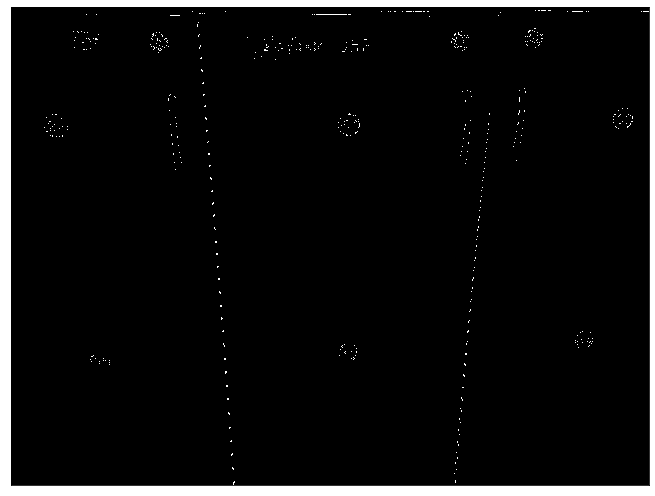

In [7]:
# perform edge detection, then perform a dilation + erosion to
# close gaps in between object edges
edged = cv.Canny(blured, 50, 100)
plt.xticks([]),plt.yticks([])
plt.imshow(edged,cmap="gray")

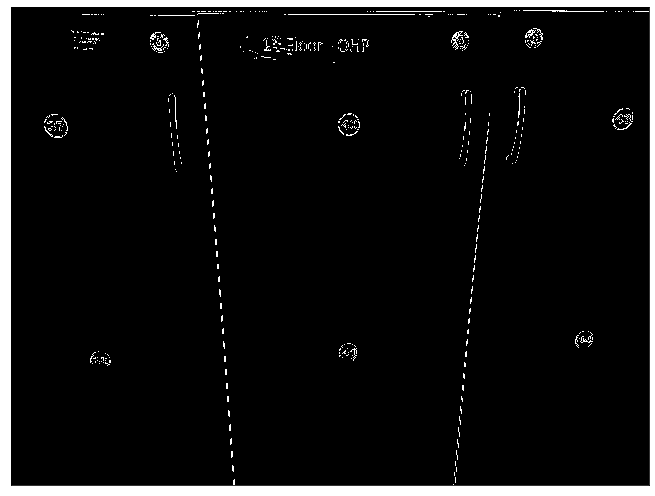

In [8]:
dilated = cv.dilate(edged, None, iterations=1)
plt.xticks([]),plt.yticks([])
plt.imshow(dilated,cmap="gray")

In [9]:
# find contours in the edge map
cnts = cv.findContours(dilated.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cnts = grab_contours(cnts)

In [10]:
# sort the contours from left-to-right and, then initialize the
# distance colors and reference object
(cnts, _) = contours.sort_contours(cnts)
colors = ((0, 0, 255), (240, 0, 159), (0, 165, 255), (255, 255, 0),(255, 0, 255))
refObj = None
pixel_width_of_ref_obj = None

In [11]:
# loop over the contours individually
orig = image.copy()
for c in cnts:
    # if the contour is not sufficiently large, ignore it
    if cv.contourArea(c) < 100:
        continue
    # compute the rotated bounding box of the contour
    box = cv.minAreaRect(c)
    box = cv.cv.BoxPoints(box) if is_cv2() else cv.boxPoints(box)
    box = np.array(box, dtype="int")
    
    # order the points in the contour such that they appear
    # in top-left, top-right, bottom-right, and bottom-left
    # order, then draw the outline of the rotated bounding
    # box
    
    box = perspective.order_points(box)
    # compute the center of the bounding box
    cX = np.average(box[:, 0])
    cY = np.average(box[:, 1])
    
    # if this is the first contour we are examining (i.e.,
    # the left-most contour), we presume this is the
    # reference object
    
    if refObj is None:
        
        # unpack the ordered bounding box, then compute the
        # midpoint between the top-left and top-right points,
        # followed by the midpoint between the top-right and
        # bottom-right
        
        (tl, tr, br, bl) = box
        (tlblX, tlblY) = midpoint(tl, bl)
        (trbrX, trbrY) = midpoint(tr, br)
        # compute the Euclidean distance between the midpoints,
        # then construct the reference object
        D = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))
        # the refObj has three values
        # 4 corner values as box(numpy array)
        # center points cX,cY,
        #actual real world size D/sticker_diameter
        refObj = (box, (cX, cY), D / sticker_diameter)
        pixel_width_of_ref_obj = D
        cv.drawContours(orig, [refObj[0].astype("int")], -1, (0, 255, 0), 2)
        refCoords = []
        refCoords.append(refObj[1])
        continue
        
    # draw the contours on the image
    cv.drawContours(orig, [box.astype("int")], -1, (0, 255, 0), 2)
    
    # stack the reference coordinates and the object coordinates
    # to include the object center
#     refCoords = np.vstack([refObj[0], refObj[1]])
#     objCoords = np.vstack([box, (cX, cY)])
    objCoords = []
    objCoords.append((cX, cY))

    #loop over the original points
    for ((xA, yA), (xB, yB), color) in zip(refCoords, objCoords, colors):
        # draw circles corresponding to the current points and
        # connect them with a line
        cv.circle(orig, (int(xA), int(yA)), 5, color, -1)
        cv.circle(orig, (int(xB), int(yB)), 5, color, -1)
        cv.line(orig, (int(xA), int(yA)), (int(xB), int(yB)),color, 2)
        # compute the Euclidean distance between the coordinates,
        # and then convert the distance in pixels to distance in
        # units
        D = dist.euclidean((xA, yA), (xB, yB)) / refObj[2]
        (mX, mY) = midpoint((xA, yA), (xB, yB))
        cv.putText(orig, "{:.1f}mm".format(D), (int(mX), int(mY - 10)),
        cv.FONT_HERSHEY_SIMPLEX, 2, color, 2)

In [12]:
cv.imwrite("distances.jpg",orig)

True

In [13]:
def distance_to_camera(knownWidth, focalLength, perWidth):
    # by using the relationship F/P = D/W
    #compute and return the distance from the maker to the camera
    return (knownWidth * focalLength) / perWidth

In [14]:
camera_distance = distance_to_camera(sticker_diameter,45.72,pixel_width_of_ref_obj)

In [15]:
camera_distance # in mm

7.403569931873806

In [16]:
pixel_width_of_ref_obj

185.26197667087544